In [1]:
from pathlib import Path
import re
import itertools
from functools import reduce
import os

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as mcolors


from lobib import DataLoader

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

os.makedirs("../figures/fit", exist_ok=True)

def save_fig(name):
    plt.savefig(f"../figures/fit/{name}.pdf", bbox_inches='tight')
    plt.savefig(f"../figures/fit/{name}.png", bbox_inches='tight', dpi=150)

In [8]:
def plot_theta_pnl(ticker: str) -> None:
    path = Path(f"/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/{ticker}/")
    files = list(path.glob("result_alpha_no_impact_k1.0_race_theta*_pnl.csv"))
    pnlnr = pl.read_csv(f"../data/results/{ticker}/result_alpha_no_impact_k1.0_norace_pnl.csv")
    pnlr = dict(sorted({float(re.search(r'_theta(\d+\.\d+)', f.as_posix()).group(1)): pl.read_csv(f) for f in files}.items()))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    
    # Create colormap for theta values
    thetas = sorted(pnlr.keys())
    norm = mcolors.Normalize(vmin=min(thetas), vmax=max(thetas))
    cmap = cm.viridis
    
    for theta, p in pnlr.items():
        if theta > 0:
            x = p["lag_sec"] / 60
            y = p["alpha_tickreturn_cov"]
            ci = p["alpha_tickreturn_cov_ci"]
            color = cmap(norm(theta))
            ax1.plot(x, y, marker="o", ms=0, mec="k", lw=1.5, color=color)
            ax1.fill_between(x, y - ci, y + ci, alpha=0.2, color=color)
    
    # No race line in red
    x = pnlnr["lag_sec"] / 60
    y = pnlnr["alpha_tickreturn_cov"]
    ci = pnlnr["alpha_tickreturn_cov_ci"]
    ax1.plot(x, y, marker="o", ms=0, mec="k", lw=1.5, color="tab:red", label="No Race")
    ax1.fill_between(x, y - ci, y + ci, alpha=0.3, color="tab:red")
    
    # Add colorbar for theta
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax1, pad=0.02)
    cbar.set_label(r"$\theta$")
    
    ax1.legend()
    ax1.set_xlabel("Horizon (minutes)")
    ax1.set_ylabel("ticks")
    ax1.set_title(
      r"$\mathbb{E}\left[\alpha_t \cdot \left(P_{t+\Delta t} - P_t\right)\right] \text{ vs } \Delta t$ (With Races)"
    )
    ax1.axhline(0, color="gray", linestyle="--", lw=0.8)
    ax1.grid(True, alpha=0.3)
    
    
    x, y = [], []
    for theta, p in pnlr.items():
      x.append(theta)
      y.append(p["alpha_tickreturn_cov"].last())
    
    ax2.plot(x, y, marker="o", ms=3, mec="k")
    ax2.axhline(pnlnr["alpha_tickreturn_cov"].last(), linestyle="--", color="tab:red", label="No race")
    
    ax2.set_title(
      r"$\mathbb{E}\left[\alpha_t \cdot \left(P_{t+\Delta t} - P_t\right)\right] \text{ vs } \theta$"
    )
    ax2.set_ylabel("ticks")
    ax2.set_xlabel(r"$\theta$")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f"ticker: {ticker}")
    plt.show()


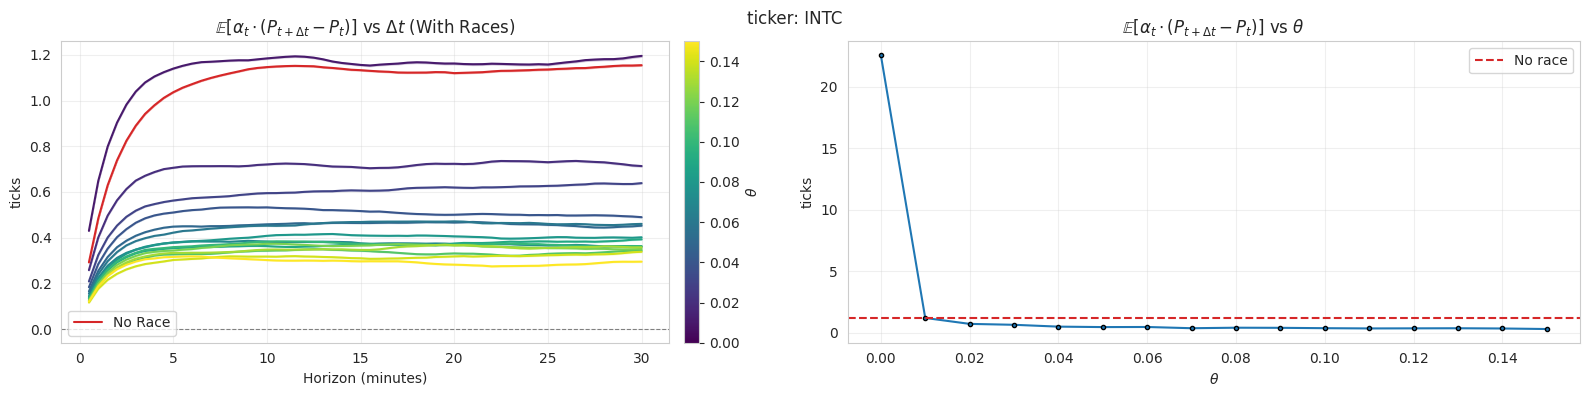

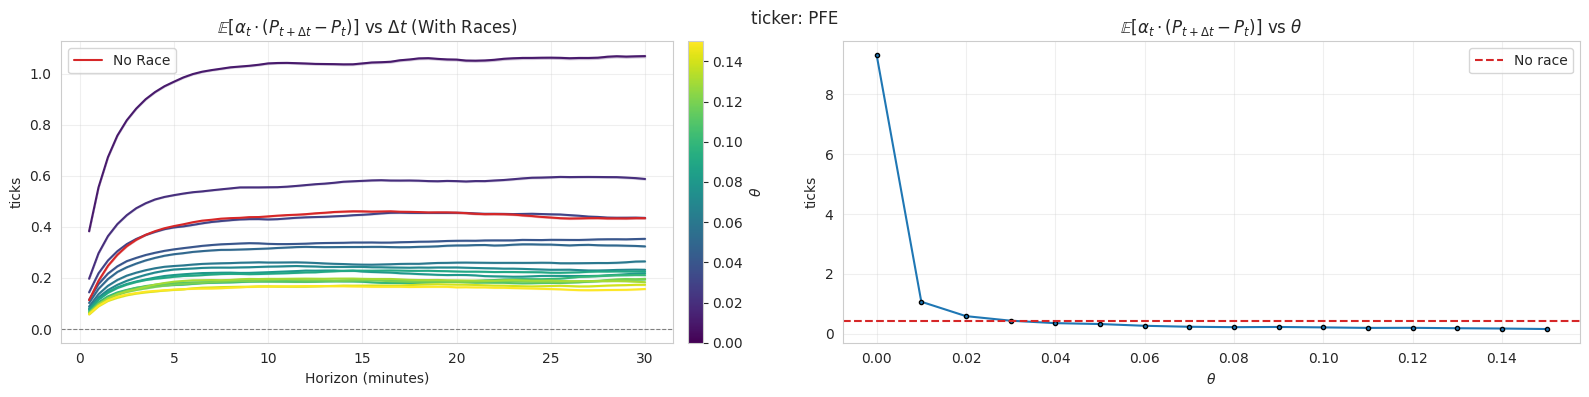

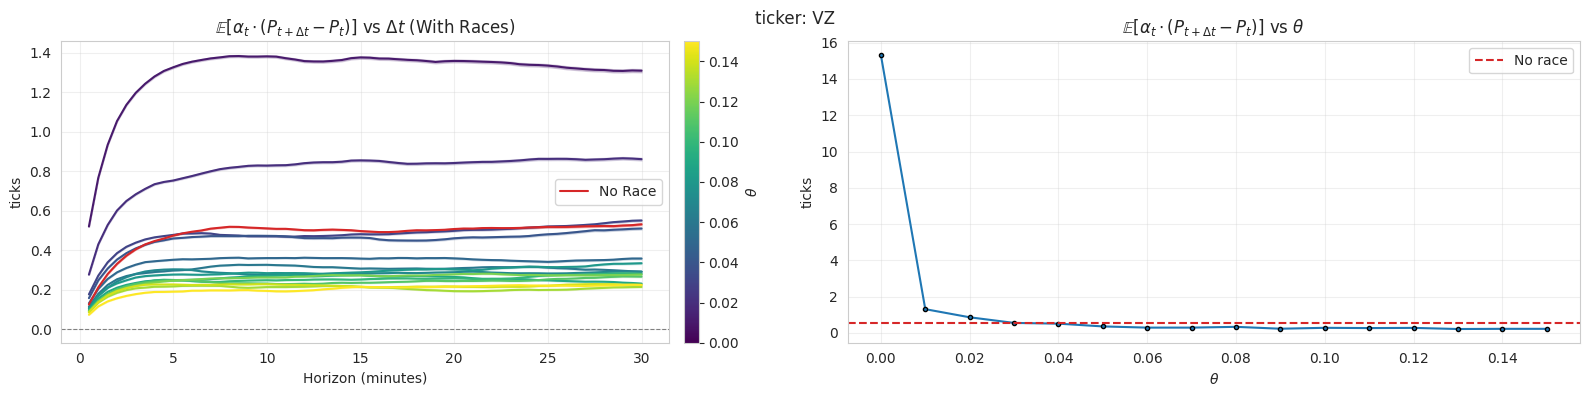

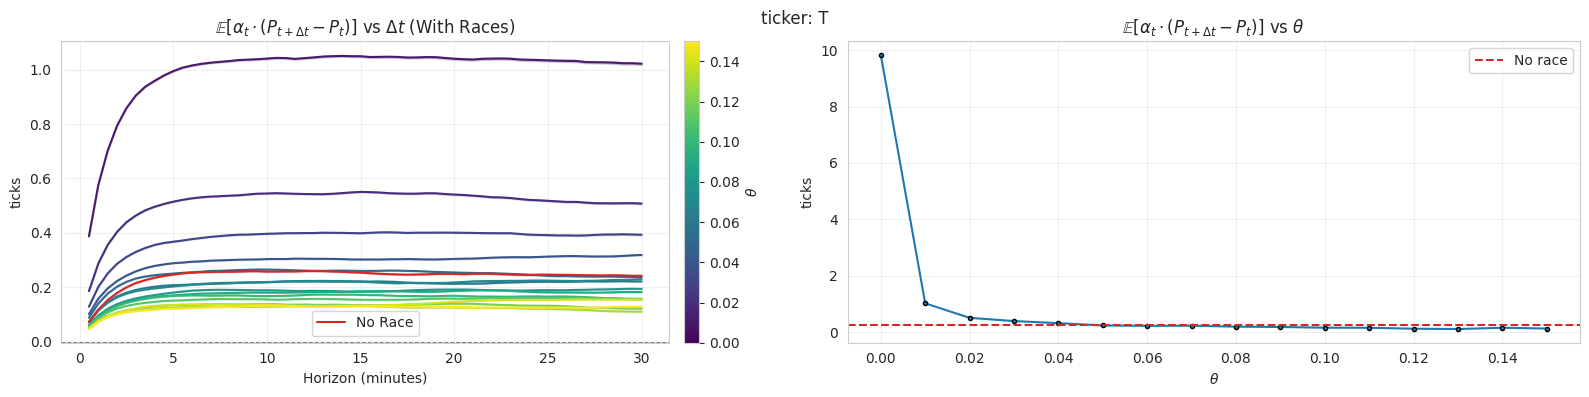

In [9]:
for ticker in ["INTC", "PFE", "VZ", "T"]:
    plot_theta_pnl(ticker)